# Improved Simulated Annealing in Julia
### With (possibly useful) Applications

#### Videh Seksaria, 6-3

In [1]:
using Distances
using Gadfly
using MultivariateStats
using Optim
using Plots
using PyPlot
using RDatasets

In [2]:
include("opt_test.jl")
include("SA.jl")

sa (generic function with 1 method)

# Multimodal Optimization (in Blackbox)

We want to minimize a loss function $$f(x): \mathbb{R}^{n} \rightarrow \mathbb{R}$$
that we do not know the analytic form of. For some cost, $c(x, p)$, we can evaluate the function to a given precision $p$.

This is hard. Consider a common evalution function like Rastrigin's:
<img src='Rastrigin_function.png'>
Even for a human, this would not neccesarily be an easy problem to solve. Unlike many optimization problems, we rarely have domain specific knowledge. A common set of inputs include only upper and lower bounds on the function, or a bounding box to search for optima over.

A good solver should:
* Find the global optima, even if $x_{0}$ is close to a local optima
* Return similar solutions given random $x_{0}$s
* Use as few function evaluations as possible
* Hill Climb well

Common solutions that do not pass these criteria are:
* Exhaustive search (costly)
* Random search (random, poor hill climbing)
* Deterministic search (rarely finds global optima)

Because of tricky functions that are:
* Non-convex
* Multimodal
* Noisy
* High dimensional
* Non-seperable
* Ill-conditioned

In other words, we need algorithms that explore the search space, and further optimize good solutions.

Let's go a little further, and add another constraint: no gradients. Functions with peaks, holes, and other messes are not well suited to gradient methods. Plus, automatic differentiation is not a perfect science, so, lets try and steer away from anything that requires computing a gradient.

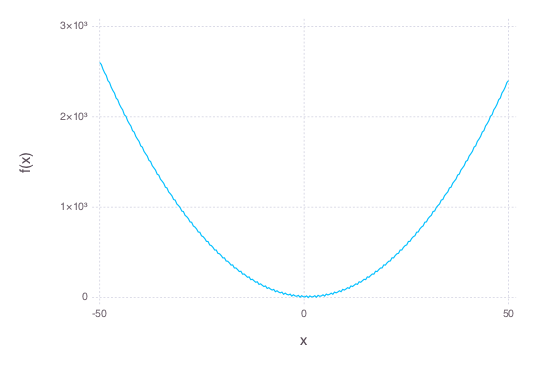

In [3]:
Gadfly.plot(rastrigin, -50, 50)

# Genetic Algorithms
|Classical Algorithms|Genetic Algorithms|
|:----------:|:-------------:|
| Deterministically generate next point | Generate a (random) population of points |
| Sequence of points approaches optima  | Population best approaches optima        |

We want to generate a population of solutions
* moving in the general direction of the best solutions
* while still searching the spacce
* and using randomness to our advantage

* Selection
    * How do we chose individuals?
    * Roulette Wheel Selection
        * Selection probability $\propto$ fitness
* Crossover
    * How can we create the next generation population
    * Incoroprate some features from different solutions
* Mutation
    * Add randomness
        * Even the best solutions can be nudged a little
        * Helps escaping from local optima
        
Let's get started with the problem of matrix inversion. Suppose we are given $M$, let's try and compute $M^{-1}$ with as little knowledge about $M$ and matrix inversion as possible. In fact, lets not use any fancy properties of inverses, or row reduction, or etc. Let's just use the fact that $MM^{-1} = I$.


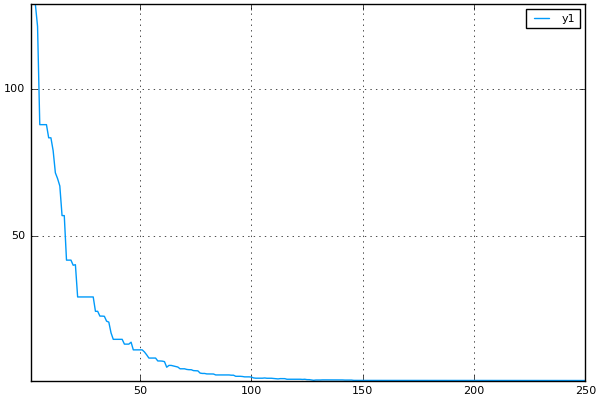

In [4]:
function inverse_sse(start, target, curr)
    prod = start * reshape(curr, (dims, dims))
    return sum((target - prod).^2)
end

function ga(y, X)
    m, n = size(X)
    pop = []
    for i in 1:25000
        push!(pop, rand(-10:10, m * n))
    end

    cache = convert(Int64, round(0.2 * 25000))
    hist = []
    best = []

    for i in 1:250
        scores = [inverse_sse(y, X, v) for v in pop]
        ordered = sortperm(scores)
        ranked = pop[ordered]
        pop = ranked[1:cache]

        while length(pop) < 25000
            if rand() < 0.3  # Mutation
                k = rand(1:25000)
                copy = ranked[k]
                i = rand(1:size(copy, 1))
                copy[i] += rand(-1:1)
                copy[i] = copy[i] < -10 ? -10 : copy[i]
                copy[i] = copy[i] > 10 ? 10 : copy[i]
                push!(pop, copy)
            else  # Crossover
                loc_1, loc_2 = rand(1:25000), rand(1:25000)
                i = rand(1:size(ranked[loc_1], 1))
                push!(pop, [ranked[loc_1][1:i]; ranked[loc_2][i+1:end]])
            end
        end
        push!(hist, scores[ordered[1]])
        best = ranked[ordered[1]]
    end
    return hist, best
end

dims = 5
random_matrix = rand(dims, dims)
identity = eye(dims);
gopt = ga(random_matrix, identity)
Plots.plot(gopt[1])

In [5]:
println(minimum(gopt[1]))
random_matrix * reshape(gopt[2], (dims, dims))

0.7026218719344808


/Users/videhs/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


5×5 Array{Float64,2}:
  1.08501    -0.194576   0.12218     0.123949   0.155708 
 -0.157767    1.1196    -0.238097    0.178103   0.0365018
 -0.0938361   0.107935   1.09089     0.059745   0.212357 
 -0.311672    0.305154   0.0812984   0.785378  -0.0501038
 -0.160754    0.253956  -0.201846   -0.133352   1.04878  

So, why did our genetic algorithm do so poorly? One major possibility lies within the crossover function, or how we combine two previous solutions to create a new one. And, what about all those parameters? Populations sizes, and probabilites, and ...? One of our goals is to create as simple a framework as we can, to do as much as possible. For that, we turn to Simulated Annealing.

# Simulated Annealing
|Genetic Algorithms|Simulated Annealing|
|:----------:|:-------------:|
| Population | Single State |
| Create next generation by crossover and mutation  | Choose next point randomly        |
| Always use new generation  | Possibly remain at current state|

Note that if we really want simulated annealing to have population-like behvarior, we can use Multistart, and randomly initiliaze starting values across the optimization landscape. This is very, very parallelizable!

Psuedocode:
* Start at initial state s
* For iter in 1:max_iter
    * tempreture = start_tempreture * iter/max_iter
    * random_state = neighbor(s)
    * if P(f(s), f(random_state), tempreture) > rand()
        * s = random_state
* return s

Note that we tend to be more lenient accepting poor solutions early on (explore the landscape), and only accept strictly better solutions as the tempreture cools (converge to optima). Of course, as the tempreture cools, we also want to have a smaller and smaller space to have to search, as we are less and less likely to explore. More formally, the Metropolis Criteria accepts with higher probability if the tempreture is higher, and the move is less suboptimal.

The current implementation of simulated annealing in Optim.jl (simulated_annealing.jl) does not
* check for convergence
* reduce the search space as the tempreture cools

Lets slightly improve it...

Currently, the random_state generated from a neighbor is not very formal... Suppose we are currently at $x$. We want to choose a random state $x'$ such that $|x'-x| \leq s$, for $s$ the step-size limit. As we begin to converge, we $s$ to decrease as well. Instead of controlling $s$ seperately, we continuosly adjust each element of $s$ so that $1/2$ of the moves in that direction are acception. This leads to a (non-monotinically) decreasing $||s||$, though the algorithm is free to adapt to extreme luck.

# Testing and Evaluation
We can evaluate this new function against Optim.jl on a standard set of benchmark functions. I could not find a large library of multimodal test functions for Julia, so I wrote my own, opt_test.jl. We have ~30 functions organized into a few categories. Lets take a look at a few, and compare the results between Optim.jl's Simulated Annealing, and SA's sa.

In [6]:
#Plot Multimodal Function
function plot_3d(f; box = 5, n = 100)
    x = linspace(-box, box, n)
    y = linspace(-box, box, n)

    xgrid = repmat(x', n, 1)
    ygrid = repmat(y, 1, n)
    z = zeros(n, n)

    for i in 1:n
        for j in 1:n
            z[i:i, j:j] = f([x[i];y[j]])
        end
    end

    fig = figure("pyplot_surfaceplot", figsize = (10, 10))
    ax = fig[:add_subplot](2, 1, 1, projection = "3d")
    ax[:plot_surface](xgrid, ygrid, z, rstride = 2, edgecolors = "k", cstride = 2, cmap = ColorMap("gray"), alpha = 0.8, linewidth = 0.25)
    xlabel("X")
    ylabel("Y")
    title(ucfirst(string(f)) * " function plot over " * " [-" * string(box) * ", " * string(box) * "]")
end

#Display Function, and show results
function compare_sa_optim(f, box, lb, ub)
    plot_3d(f, box=box)
    sleep(1)
    println(optimize(f, zeros(2), SimulatedAnnealing()))
    sa_opt = sa(f, zeros(2), lb, ub, eval_lim=1000)
    println("SA:")
    println(f(sa_opt))
end

compare_sa_optim (generic function with 1 method)

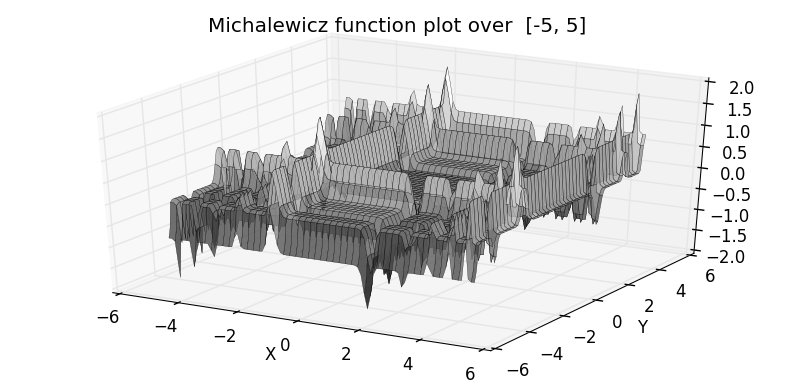

Results of Optimization Algorithm
 * Algorithm: Simulated Annealing
 * Starting Point: [0.0,0.0]
 * Minimizer: [-11.966467272854997,-4.723434291307347]
 * Minimum: -1.517085e+00
 * Iterations: 1000
 * Convergence: false
   * |x - x'| < NaN: false
   * |f(x) - f(x')| / |f(x)| < NaN: false
   * |g(x)| < NaN: false
   * Reached Maximum Number of Iterations: true
 * Objective Function Calls: 1001

SA:
-1.8013031351801545


In [29]:
#For d = 2, min(f) = -1.8013 at (2.20, 1.57)
sa_opt = compare_sa_optim(michalewicz, 5, [0, 0], [pi, pi]);

Results of Optimization Algorithm
 * Algorithm: Simulated Annealing
 * Starting Point: [0.0,0.0]
 * Minimizer: [-7.017850692089551,1.1315543674224626]
 * Minimum: 6.878937e-01
 * Iterations: 1000
 * Convergence: false
   * |x - x'| < NaN: false
   * |f(x) - f(x')| / |f(x)| < NaN: false
   * |g(x)| < NaN: false
   * Reached Maximum Number of Iterations: true
 * Objective Function Calls: 1001

SA:

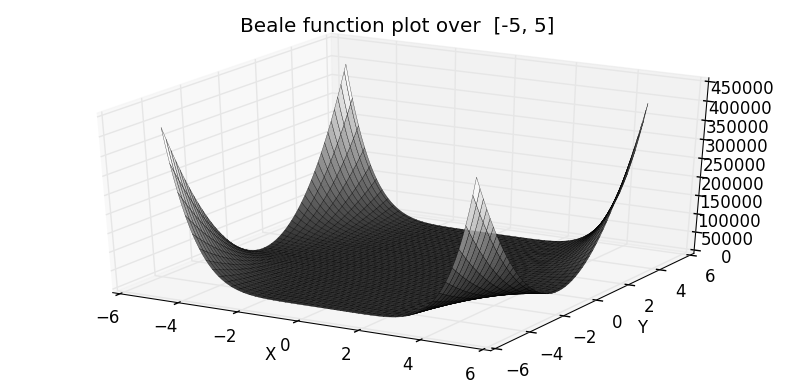


1.1358432930113375e-5


In [8]:
#For d = 2, min(f) = 0 at (3, 0.5)
sa_opt = compare_sa_optim(beale, 5, [-4.5, -4.5], [4.5, 4.5]);

Results of Optimization Algorithm
 * Algorithm: Simulated Annealing
 * Starting Point: [0.0,0.0]
 * Minimizer: [2.744165695152424,-2.923510518790413]
 * Minimum: -6.418856e+01
 * Iterations: 1000
 * Convergence: false
   * |x - x'| < NaN: false
   * |f(x) - f(x')| / |f(x)| < NaN: false
   * |g(x)| < NaN: false
   * Reached Maximum Number of Iterations: true
 * Objective Function Calls: 1001



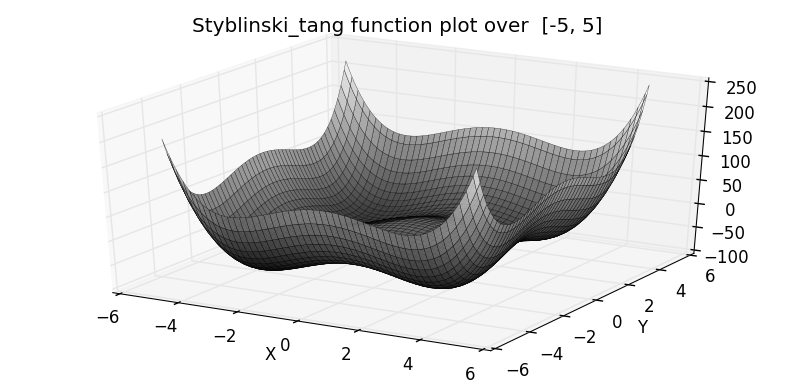

SA:
-78.33233114255489


In [9]:
#For d = 2, min(f) = -78.33198 at (-2.903534..., -2.903534...)
sa_opt = compare_sa_optim(styblinski_tang, 5, [-5.0, -5.0], [5.0, 5.0]);

Thats exciting! We're clearly doing better than our baseline. Even more exciting that raw numbers, is the stability. Our results are far more consistent over multiple runs. But what about our genetic algorithm? Our motivation was to be able to better invert matrices. Lets take a look.

In [31]:
dim = 4
a = inv(rand(dim, dim))
eye_a = eye(dim)
function sse(x)
    sum((a*reshape(x, (dim, dim)) - eye_a) .^ 2)
end

x = 0.5 * reshape(ones(dim, dim), dim^2)
lb = reshape(zeros(dim, dim), dim^2)
ub = reshape(ones(dim, dim), dim^2)

xopt = sa(sse, x, lb, ub, eval_lim=1000000)
a * reshape(xopt, (dim, dim))

4×4 Array{Float64,2}:
  1.0         -2.86051e-6  6.07954e-6  4.49523e-6
  4.04979e-6   0.999992    1.18484e-5  1.68885e-5
 -4.03507e-7   2.16969e-7  1.00001     1.1529e-5 
  1.25721e-6  -6.87767e-6  1.166e-5    1.00001   

That is much, much, much better. Admittedly, its not perfect, and RREF could certainly do a better job. But, it looks like an intelligent random search is performing much better than our crossovers. To be clear, SA (in general) performs worse than GA (in general). However, SA implementations tend to be more flexible and require less customization. And, isn't that really our goal in the end?

# Applications
## K-Means Clustering

K-Means clustering is a very population unsupervised learning technique. The basic problem is as follows:
For points $(x_{1}, x_{2}, \dots, x_{n})$, divide these $n$ points into $k$ sets $(s_{1}, s_{2}, \dots, s_{k})$ to find $$\min_{s} \sum_{i=1}^{k}\sum_{x\in s_{i}}^{}||x-\mu_{i} ||^2$$

There are many iterative procedures to solve this problem. Most of which revolve around the basic idea of picking random clusters, assigning points to the best cluster, and then fitting each cluster to minimize the distance to its points. Then, repeat.

Instead, lets just consider this is a problem of minimizing our objective function.

In [11]:
xclara = dataset("cluster", "xclara"); #Bivariate Data Set with 3 Clusters

3000×2 DataFrames.DataFrame
│ Row  │ V1      │ V2       │
├──────┼─────────┼──────────┤
│ 1    │ 2.07234 │ -3.24169 │
│ 2    │ 17.9367 │ 15.7848  │
│ 3    │ 1.08358 │ 7.31918  │
│ 4    │ 11.1207 │ 14.4068  │
│ 5    │ 23.7115 │ 2.55773  │
│ 6    │ 24.1699 │ 32.0248  │
│ 7    │ 21.6658 │ 4.89285  │
│ 8    │ 4.69368 │ 12.3422  │
│ 9    │ 19.2119 │ -1.12137 │
│ 10   │ 4.23039 │ -4.44154 │
│ 11   │ 9.12713 │ 23.6057  │
⋮
│ 2989 │ 85.5191 │ -22.0943 │
│ 2990 │ 76.5364 │ -11.3925 │
│ 2991 │ 48.342  │ -9.15055 │
│ 2992 │ 69.6929 │ -7.06763 │
│ 2993 │ 79.8628 │ -16.0177 │
│ 2994 │ 69.803  │ 4.93805  │
│ 2995 │ 83.6518 │ -18.7392 │
│ 2996 │ 85.6528 │ -6.46106 │
│ 2997 │ 82.7709 │ -2.3733  │
│ 2998 │ 64.4653 │ -10.5014 │
│ 2999 │ 90.7228 │ -12.2558 │
│ 3000 │ 64.8798 │ -24.8773 │

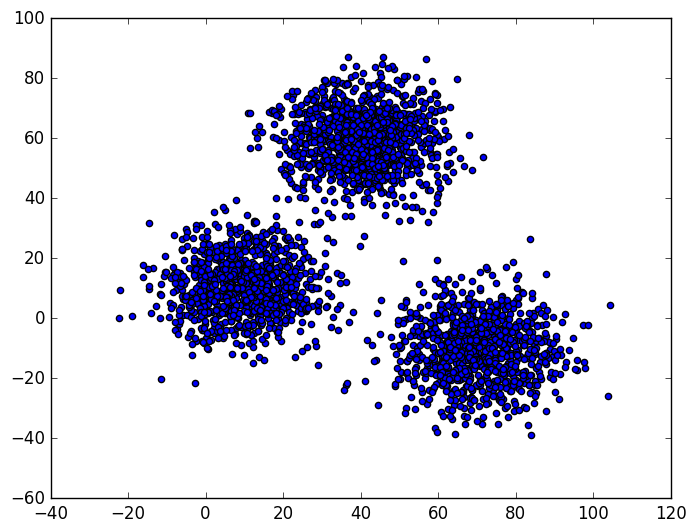

cluster_labels (generic function with 1 method)

In [12]:
xclara = dataset("cluster", "xclara");
PyPlot.scatter(xclara[:, 1], xclara[:, 2])
centers = [[10, 10], [40, 60], [70, -20]]

function cluster_distance(x)
    err = 0.0
    for i in 1:size(xclara, 1)
        pt = array(xclara[i, :])
        err += min(euclidean(pt, x[1:2]),
                   min(euclidean(pt, x[3:4]),
                       euclidean(pt, x[5:6])))
    end
    return err
end

function cluster_labels(x; k=3)
    labels = zeros(size(xclara, 1))
    for i in 1:size(xclara, 1)
        label = 1
        pt = array(xclara[i, :])
        for j in 2:k
            if euclidean(pt, x[j]) < euclidean(pt, x[label])
                label = j
            end
        end
        labels[i] = label
    end
    return labels
end

 in depwarn(::

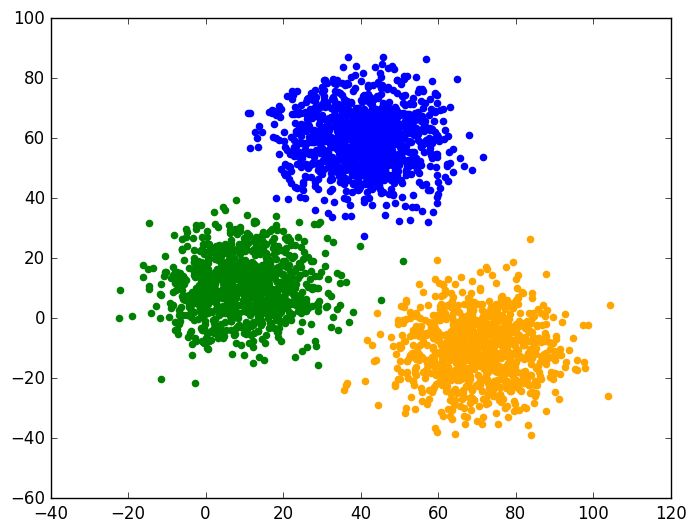

String, ::Symbol) at ./deprecated.jl:64
 in array(::DataFrames.DataFrame) at ./deprecated.jl:50
 in #cluster_labels#11(::Int64, ::Function, ::Array{Array{Int64,1},1}) at ./In[12]:20
 in cluster_labels(::Array{Array{Int64,1},1}) at ./In[12]:17
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/videhs/.julia/v0.5/IJulia/src/execute_request.jl:169
 in eventloop(::ZMQ.Socket) at /Users/videhs/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##9#15)() at ./task.jl:360
while loading In[13], in expression starting on line 1


PyObject <matplotlib.collections.PathCollection object at 0x32c7342d0>

In [13]:
labels = cluster_labels(centers)
PyPlot.scatter([xclara[i, 1] for i in find(labels -> labels == 1.0, labels)],
               [xclara[i, 2] for i in find(labels -> labels == 1.0, labels)],
               color="green")
PyPlot.scatter([xclara[i, 1] for i in find(labels -> labels == 2.0, labels)],
               [xclara[i, 2] for i in find(labels -> labels == 2.0, labels)],
               color="blue")
PyPlot.scatter([xclara[i, 1] for i in find(labels -> labels == 3.0, labels)],
               [xclara[i, 2] for i in find(labels -> labels == 3.0, labels)],
               color="orange")

Note that our cost function is simply:
* For every point
    * err += distance(point, closest cluster center)

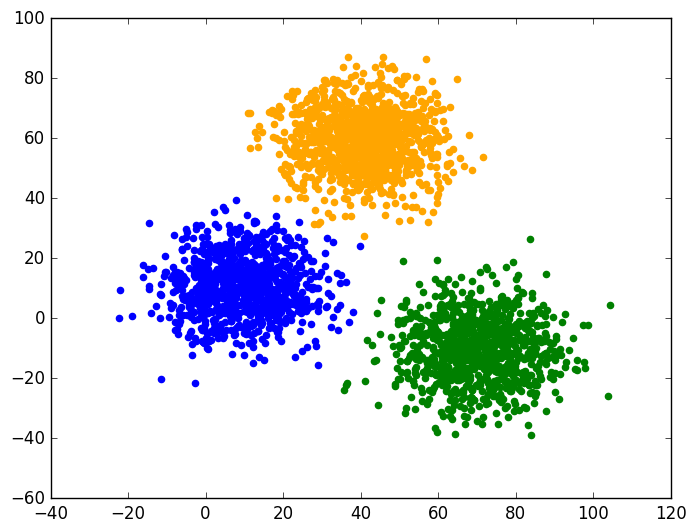

  likely near /Users/videhs/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/videhs/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/videhs/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/videhs/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/videhs/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/videhs/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/videhs/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/videhs/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/videhs/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/videhs/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/videhs/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/videhs/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/videhs/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/videhs/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /Users/videhs/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/videhs/.julia/v0.5/PyCall/sr

PyObject <matplotlib.collections.PathCollection object at 0x32649c4d0>

In [14]:
x = [0.0, 0.0, 20.0, 20.0, 100.0, 70.0]
lb = [-20.0, -40.0, -20.0, -40.0, -20.0, -40.0]
ub = [120.0, 100.0, 120.0, 100.0, 120.0, 100.0]

xopt = sa(cluster_distance, x, lb, ub, eval_lim=100)

labels = cluster_labels([xopt[1:2], xopt[3:4], xopt[5:6]])
PyPlot.scatter([xclara[i, 1] for i in find(labels -> labels == 1.0, labels)],
               [xclara[i, 2] for i in find(labels -> labels == 1.0, labels)],
               color="green")
PyPlot.scatter([xclara[i, 1] for i in find(labels -> labels == 2.0, labels)],
               [xclara[i, 2] for i in find(labels -> labels == 2.0, labels)],
               color="blue")
PyPlot.scatter([xclara[i, 1] for i in find(labels -> labels == 3.0, labels)],
               [xclara[i, 2] for i in find(labels -> labels == 3.0, labels)],
               color="orange")

Wow! It looks like we did a very, very good job on that task. So, why would we ever want to do this? We have procedures like K-Means, EM, and many, many more available... One benefit is that procedures are a structured way to generate a given result. On the other hand, here, we are directly minimizing the loss function we want to minimize, not minimizing some loss function which is a good proxy for what we want to minimize.

Secondly, it makes modifications trivial! Suppose, we did not know that we have $k = 3$ clusters. One possible method of finding the optimal $k$ would be to use the BIC score. Directly with K-Means, we would have to solve a K-Means instance for $k = 1, 2, ..., n$, while here we can modify our loss function to be $-2\log{L}+k\ln{n}$, and viola... we are now solving two problems in one!

## Classification
Lets look at a related, supervised task. Here, we want to find a linear seperator between a set of points. Note that to make this task (slightly) harder, we add some random jitter to the points. This effectively means that if we were to (directly) run perceptron, we would never converge.

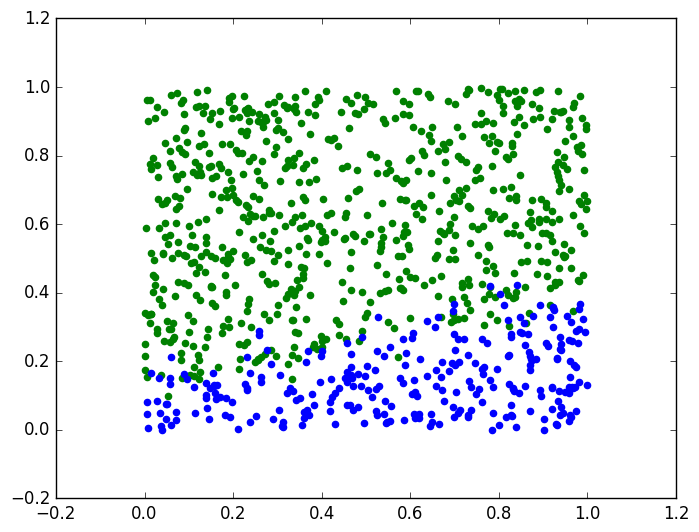

PyObject <matplotlib.collections.PathCollection object at 0x32b869550>

In [15]:
n_pts = 1000
pts = rand(n_pts, 2);

above = []
below = []

line = [.25, .25]  # Boundary: y = .25(x + 1)
for i in 1:n_pts
    # Add some random jitter to make the data not 100% linearly sperable
    if (pts[i, 2] + .2 * rand(1)[1]) >= line[1] * pts[i, 1] + line[2]
        push!(above, pts[i, :])
    else
        push!(below, pts[i, :])
    end
end

PyPlot.scatter([x[1] for x in above], [x[2] for x in above], color="green")
PyPlot.scatter([x[1] for x in below], [x[2] for x in below], color="blue")

Our points have a divided around $y = .25(x + 1)$. Lets see how well we do...

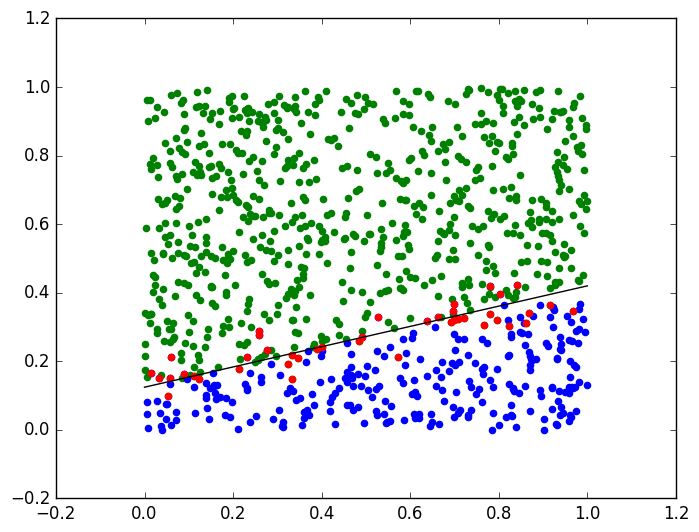

PyObject <matplotlib.collections.PathCollection object at 0x32c83f310>

In [16]:
function binary_distance(x)
    err = 0.0
    for i in 1:n_pts
        if pts[i, 2] >= x[1] * pts[i, 1] + x[2]
            if !(pts[i, :] in above)
                err += (abs(x[1] * pts[i, 1] - pts[i, 2] + x[2]) / sqrt(x[1] ^ 2 + x[2] ^ 2)) ^ 2
            end
        else
            if !(pts[i, :] in below)
                err += (abs(x[1] * pts[i, 1] - pts[i, 2] + x[2]) / sqrt(x[1] ^ 2 + x[2] ^ 2)) ^ 2
            end
        end
    end
    return err
end

x = [.5, .5]
lb = [0.0, 0.0]
ub = [1.0, 1.0]

xopt = sa(binary_distance, x, lb, ub, eval_lim=100000)

function incorrectly_classified(x)
    wrong_pts = []
    for i in 1:n_pts
        if pts[i, 2] >= x[1] * pts[i, 1] + x[2]
            if !(pts[i, :] in above)
                 push!(wrong_pts, pts[i, :])
            end
        else
            if !(pts[i, :] in below)
                push!(wrong_pts, pts[i, :])
            end
        end
    end
    return wrong_pts
end

wrong_pts = incorrectly_classified(xopt)
PyPlot.scatter([x[1] for x in above], [x[2] for x in above], color="green")
PyPlot.scatter([x[1] for x in below], [x[2] for x in below], color="blue")
PyPlot.plot(linspace(0.0, 1.0, 1000), xopt[1] * linspace(0.0, 1.0, 1000) + xopt[2], color="black")
PyPlot.scatter([x[1] for x in wrong_pts], [x[2] for x in wrong_pts], color="red")

Not bad! Suppose our data was a little more spaced out. And, instead of just learning a linear seperator, we were interested in learning the best linear seperator. One possible way to define best, would be the one with the least generalization error. Short of having the test data, a reasonable claim would be the linear seperator that puts the most space between it and the points.

SVMs are a very popular technique of finding the best linear decision boundary. At their heart, this is really a passive-agressive problem, where we want to maximize our seperability, while minimizing some penalty $\lambda||x||$. Had we implemented a perceptron algorithm (or averaged percepton, or ...), we would have to re-write our entire algorithm from scratch. Instead, here, we could simply add the penalty term to our cost function.

Of course, the direct optimization - based paradigm to ML is not perfect. Our output is only as good as our cost function. Suppose we had the following two circles dataset.

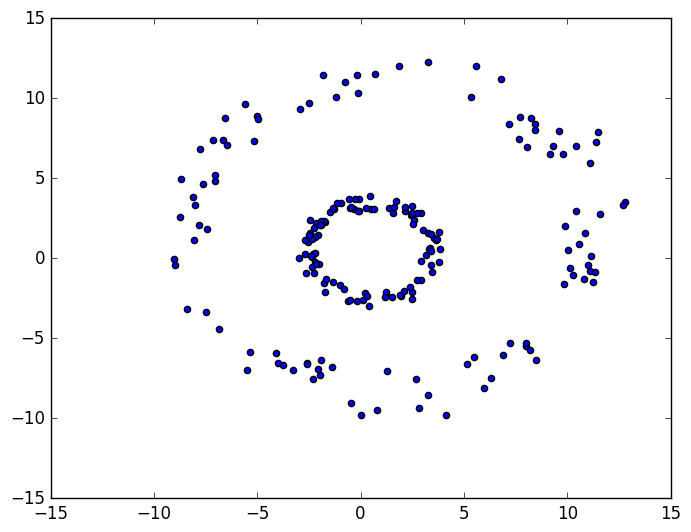

PyObject <matplotlib.collections.PathCollection object at 0x32b9f5590>

In [17]:
r = 3
theta = 360 * rand(100)
x_1 = r * cos(theta) + rand(100)
y_1 = r * sin(theta) + rand(100)
PyPlot.scatter(x_1, y_1)

r = 10
theta = 360 * rand(100)
x_2 = r * cos(theta) + 3 * rand(100)
y_2 = r * sin(theta) + 3 * rand(100)
PyPlot.scatter(x_2, y_2)

And attempted to cluster into two groups as we did above. We might want our output to have an inner and outer cluster. But, ...

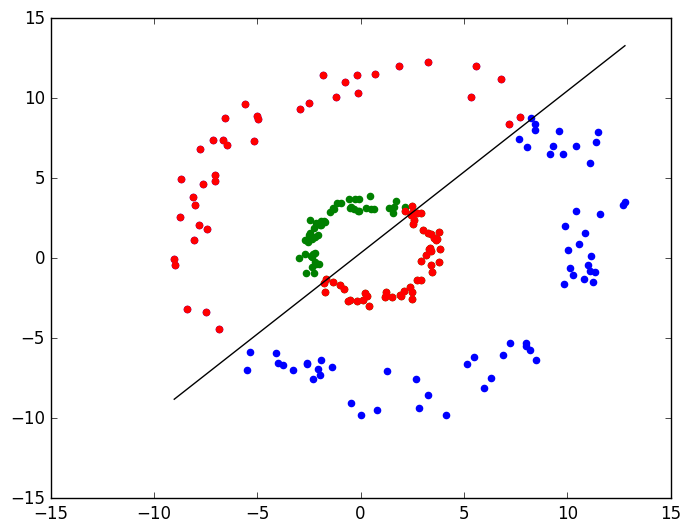

PyObject <matplotlib.collections.PathCollection object at 0x32c4ed990>

In [18]:
pts = vcat(hcat(x_1, y_1), hcat(x_2, y_2))
above = [[x_1[i], y_1[i]] for i in 1:100]
below = [[x_2[i], y_2[i]] for i in 1:100]
n_pts = 200

x = [.5, .5]
lb = [0.0, 0.0]
ub = [1.0, 1.0]

xopt = sa(binary_distance, x, lb, ub, eval_lim=100000)

x_min = min(minimum(x_1), minimum(x_2))
x_max = max(maximum(x_1), maximum(x_2))
y_min = min(minimum(y_1), minimum(y_2))
y_max = max(maximum(y_1), maximum(y_2))

wrong_pts = incorrectly_classified(xopt)
PyPlot.scatter([x[1] for x in above], [x[2] for x in above], color="green")
PyPlot.scatter([x[1] for x in below], [x[2] for x in below], color="blue")
PyPlot.plot(linspace(x_min, x_max, 1000), xopt[1] * linspace(y_min, y_max, 1000) + xopt[2], color="black")
PyPlot.scatter([x[1] for x in wrong_pts], [x[2] for x in wrong_pts], color="red")

We get something very, very different. This output is almost identical to that from K-Means, simply because our cost function looks for convex, spherical objects. An alternative method like Spectral Clustering, on the other hand, looks to minimize the distances between points in each cluster. If we want to group in such a manner, our cost function will need to change.

## Sentiment Prediction
Finally, we look at a very, very different (at least on the surface) task of sentiment prediction. For simplicity, lets say that sentiment can be positive, or negative. We have some training data from Kaggle containing a sentence, along with a label of $0$ or $1$.

The training data consists of movie reviews, and contains a few explicit reviews. The original task focused on generalizing from training data on reviews to general statements about Boston. Here, we attempt something similar.

In [19]:
data = open("training.txt")
lines = readlines(data)
words = []
for line in lines
    for word in split((split(line, ['\t', '\n'], keep=false))[2], ' ', keep=false)
        push!(words, word)
    end
end
close(data)

Since this is a natural language task, there is some data cleaning we have to do. Namely, remove extremely short, or long words, remove non-letter characters, and convert everything to lowercase. Once we have a list of all words we "care" about, we can create a bag of words model.

A bag of words, or unigram model is simple yet effective. We create vectors $x_{i}$ with length given by the number of words. Initially, $x_{i}=0$, and for every word in our sentence, set $x_{i}[j]=1$. So, instead of learning some meta-parameters on the sentence, we directly work with the words themselves.

In [20]:
clean_words = []
for word in Set(words)
    cleaned_word = replace(normalize_string(word, stripmark=true, stripignore=true, stripcc=true),
                          Set(",./<>?;'[]\:{}|1234567890-=~!@#%^&*()_+\$"), "")
    if 5 < length(cleaned_word) && length(cleaned_word) < 10
        push!(clean_words, lowercase(cleaned_word))
    end
end
bag_locations = Dict(clean_words[i] => i for i = 1:length(clean_words))
    
sentiments = [[], []]
for line in lines
    vector = zeros(length(clean_words))
    dir = split(line, ['\t', '\n'], keep=false)[1]
    for word in split((split(line, ['\t', '\n'], keep=false))[2], ' ', keep=false)
        cleaned_word = lowercase(replace(normalize_string(word, stripmark=true, stripignore=true, stripcc=true),
                                Set(",./<>?;'[]\:{}|1234567890-=~!@#%^&*()_+\$"), ""))
        if 5 < length(cleaned_word) && length(cleaned_word) < 10
            vector[bag_locations[cleaned_word]] = 1
        end
    end
    push!(sentiments[parse(Int, dir) + 1], vector)
end

But, with a bag of words, we have ~2,000 dimensional vectors. Our data is not nearly large enough to reliable train such a large space. So, lets transform our data to 2 dimensions using PCA, and train on that. Of course, this is a "real" problem, so our objective should take reality into account.

Suppose we are using sentiment to make trades (please, don't do this, but if you do, use Julia!), and we go long on positive messages, and do nothing on negative messages. The cost of being wrong, is greater than the cost of a missed opportunity. So, in our cost function, lets minimize the number of false positives, and ignore false negatives.

In [21]:
pca_fit_2 = fit(PCA, hcat(vcat(sentiments[1], sentiments[2])...), maxoutdim=2)
pca_negative_2 = transform(pca_fit_2, hcat(sentiments[1]...))
pca_negative_2 = [pca_negative_2[:, i] for i in 1:size(pca_negative_2, 2)]
pca_positive_2 = transform(pca_fit_2, hcat(sentiments[2]...))
pca_positive_2 = [pca_positive_2[:, i] for i in 1:size(pca_positive_2, 2)]
pca_2 = vcat(pca_negative_2, pca_positive_2)
pca_2 = hcat(pca_2...)';

In [22]:
function pca_distance(x)
    err = 0.0
    for i in 1:size(pca_2, 1)
        if pca_2[i, 2] < x[1] * pca_2[i, 1] + x[2]
            if !(pca_2[i, :] in pca_negative_2)
                err += (abs(x[1] * pca_2[i, 1] - pca_2[i, 2] + x[2]) / sqrt(x[1] ^ 2 + x[2] ^ 2)) ^ 2
            else
                err -= (abs(x[1] * pca_2[i, 1] - pca_2[i, 2] + x[2]) / sqrt(x[1] ^ 2 + x[2] ^ 2)) ^ 2
            end
        end
    end
    return err
end

x = [.5, .5]
lb = [-1.0, -1.0]
ub = [1.0, 1.0]

xopt = sa(pca_distance, x, lb, ub, eval_lim=100000);

Now that we have a classifier, we can use it. Let's give it a few sentences, and see what it says! Given the raw user input, we have to do the same data cleaning as before, and tranform our raw bag of words into our reduced space.

Note that this implementation errs if given a word it has not seen before. We could fix the (computationally) by adding a dummy spot in our dictionary, and in our model by considering a prior distribution over unigrams, and bigrams and using add $\alpha$-smoothing to fill in the gaps.

In [23]:
function sentiment_predict(sentence)
    vector = zeros(length(clean_words))
    dir = split(sentence, ['\t', '\n'], keep=false)[1]
    for word in split(sentence, ' ', keep=false)
        cleaned_word = lowercase(replace(normalize_string(word, stripmark=true, stripignore=true, stripcc=true),
                                Set(",./<>?;'[]\:{}|1234567890-=~!@#%^&*()_+\$"), ""))
        if 5 < length(cleaned_word) && length(cleaned_word) < 10
            vector[bag_locations[cleaned_word]] = 1
        end
    end
    pca_vector = transform(pca_fit_2, vector)
    return convert(Bool, pca_vector[2] < xopt[1] * pca_vector[1] + xopt[2])
end

sentiment_predict (generic function with 1 method)

The Good

Please note that some of these sentences are from test data, and some are my creations.

In [28]:
println(sentiment_predict("It was awesome. I can't wait for the book!"))
println(sentiment_predict("I love MIT"))  # This works, but should it...? Remember, we strip out words of length <= 3
println(sentiment_predict("Julia is amazing. Just the best"))
println(sentiment_predict("Make America Great Again"))
println(sentiment_predict("The lesson of was that if you can't fix something you just have to live with it."))

true
true
true
true
true


In [25]:
println(sentiment_predict("Brokeback Mountain was depressing!"))

true


The Bad

In [26]:
println(sentiment_predict("It was so depressing and awful"))
println(sentiment_predict("I hated, hated, hated it"))  # Repetition of hated is NOT captured by our model

true
true


# Conclusion
* Simulated annealing is a robust, powerful technique for optimizing tricky blackbox functions. It allows us to work on problems where we don't really understand our loss, and want to define very specific loss functions.

* Genetic algorithms, though generally considered to be "stronger" in literature require more fine tuning for a similr end result.

* Simulated annealing in Optim.jl can be improved a bit. My goal is PR over IAP.

# Thank You
# Any Questions?